# Sentiment analysis in Pytorch 1: using a simple RNN

In [1]:
# all imports
import numpy as np
import pandas as pd
import torch
from torchtext import data
import torch.optim as optim
from plots.plots import plot_confusion_matrix, plot_histogram_from_labels
from text_processing.functions import simple_pre_process_text_df, simple_pre_process_text

% matplotlib inline

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected

Speak about the dataset [First GOP debate twitter sentiment](https://www.kaggle.com/crowdflower/first-gop-debate-twitter-sentiment)

In [2]:
train_data_path = 'data/gop_tweets/train.csv'
test_data_path = 'data/gop_tweets/test.csv'

train_data = pd.read_csv(train_data_path, index_col=0)
test_data = pd.read_csv(test_data_path, index_col=0)

In [3]:
train_data.head()

,text,sentiment
0,"Fox News keeps hammering, according to plan, h...",Negative
1,"RT @LindaSuhler: Jeb Stands By ""Act of Love""; ...",Negative
2,#GOPDebate #JonVoyage - Thoughts on the events...,Neutral
3,"RT @larryelder: Trump should have said, ""Megyn...",Neutral
4,RT @NadineElhindi: A debate moderator's job is...,Negative


In [4]:
test_data.head()

,text,sentiment
0,@iDanielTX Have any of the democrat candidates...,Negative
1,RT @TheBaxterBean: Funny how Donald Trump neve...,Neutral
2,RT @RWSurferGirl: Why doesn't Chris Wallace as...,Negative
3,RT @jybray: Telling it like it is #GOPDebate h...,Negative
4,RT @RWSurferGirl: Fox News is obviously trying...,Negative


In [5]:
labels_legend = ['Negative', 'Neutral', 'Positive']
sentiment2int = {'Negative':0, 'Neutral':1, 'Positive':2}
int2sentiment = {i[1]: i[0] for i in sentiment2int.items()}
train_labels = [sentiment2int[sentiment] for sentiment in train_data["sentiment"].values]
test_labels = [sentiment2int[sentiment] for sentiment in test_data["sentiment"].values]

Plotting the data histogram

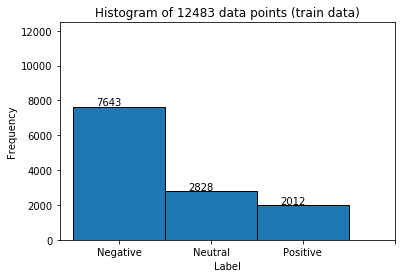

In [6]:
plot_histogram_from_labels(train_labels, ['Negative', 'Neutral', 'Positive'], "train data")

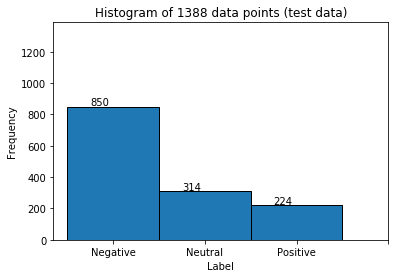

In [7]:
plot_histogram_from_labels(test_labels, ['Negative', 'Neutral', 'Positive'], "test data")

Vizualizating some tweets

In [8]:
print(train_data["text"].values[2])
print()
print(train_data["text"].values[3])
print()
print(train_data["text"].values[4])

#GOPDebate #JonVoyage - Thoughts on the events of last night on TV, including the Republican debate and Jon... http://t.co/pz4tiAOnBL

RT @larryelder: Trump should have said, "Megyn, ask these nine candidates, if they plan to support ME when I win the nomination."
#GOPDebat…

RT @NadineElhindi: A debate moderator's job is to ask tough questions, NOT to attack the candidates then play the victim. @FoxNews @megynke…


In [9]:
print("\nAFTER using the function simple_pre_process_text_df \n")
simple_pre_process_text_df(train_data)
simple_pre_process_text_df(test_data)
print(train_data["text"].values[2])
print()
print(train_data["text"].values[3])
print()
print(train_data["text"].values[4])


AFTER using the function simple_pre_process_text_df 

gopdebate jonvoyage thoughts on the events of last night on tv including the republican debate and jon httptcopz4tiaonbl

larryelder trump should have said megyn ask these nine candidates if they plan to support me when i win the nomination
gopdebat

nadineelhindi a debate moderators job is to ask tough questions not to attack the candidates then play the victim foxnews megynke


Now we can save the preprocessed text as a csv

In [10]:
train_data = train_data[["text", "sentiment"]]
test_data = test_data[["text", "sentiment"]]
train_data.to_csv('data/gop_tweets/train_clean.csv', header=False, index=False)
test_data.to_csv('data/gop_tweets/test_clean.csv', header=False, index=False)

We use the`data.Field` to hold all the text data:

> Field class models common text processing datatypes that can be represented
by tensors.  It holds a Vocab object that defines the set of possible values
for elements of the field and their corresponding numerical representations.
The Field object also holds other parameters relating to how a datatype
should be numericalized, such as a tokenization method and the kind of
Tensor that should be produced.

and the class `data.LabelField` to hold the labels:

> A label field is a shallow wrapper around a standard field designed to hold labels
for a classification task. Its only use is to set the unk_token and sequential to `None` by default.

In [11]:
TEXT = data.Field(tokenize='spacy')
LABEL = data.LabelField(tensor_type=torch.FloatTensor)

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


And so we can create a dataset by using the class `data.TabularDataset` and the data in the `csv` format

In [12]:
train = data.TabularDataset(path='data/gop_tweets/train_clean.csv',
                            format="csv",
                            fields=[('text', TEXT), ('label', LABEL)])

test = data.TabularDataset(path='data/gop_tweets/test_clean.csv',
                            format="csv",
                            fields=[('text', TEXT), ('label', LABEL)])

Creating the train-valid split (80$\%$ for training data and 20$\%$ for validation data)

In [13]:
train, valid = train.split(0.8)

In [14]:
print('len(train):', len(train))
print('len(valid):', len(valid))
print('len(test):', len(test))

len(train): 9986
len(valid): 2497
len(test): 1388


Constructing the Vocabulary, using at maximun 25000 words

In [15]:
TEXT.build_vocab(train, max_size=25000)
LABEL.build_vocab(train)

In [16]:
print('len(TEXT.vocab):', len(TEXT.vocab))
print('len(LABEL.vocab):', len(LABEL.vocab))

len(TEXT.vocab): 15843
len(LABEL.vocab): 3


Printing the 20 most frequent words

In [17]:
print(TEXT.vocab.freqs.most_common(20))

[('gopdebate', 6484), ('the', 6332), ('gopdebates', 3794), ('to', 3430), ('is', 2486), ('a', 2410), ('i', 2399), ('of', 2391), ('and', 2054), ('you', 1582), ('in', 1444), ('rwsurfergirl', 1404), ('nt', 1349), ('for', 1326), ('trump', 1297), ('it', 1281), ('on', 1174), ('that', 1127), ('\n', 1040), ('fox', 958)]


- `.itos` is the `int2str` method from the object `TEXT.vocab` 
- `.stoi` is the `str2int` method from the object `TEXT.vocab` 

In [18]:
print("TEXT.vocab.itos")
print("word", "index")

for i, word in enumerate(TEXT.vocab.itos[:10]):
    print(word, i)


print()
print("TEXT.vocab.stoi")
print("word", "index")
for word in "i love trump".split():
    print(word, TEXT.vocab.stoi[word])

TEXT.vocab.itos
word index
<unk> 0
<pad> 1
gopdebate 2
the 3
gopdebates 4
to 5
is 6
a 7
i 8
of 9

TEXT.vocab.stoi
word index
i 8
love 231
trump 16


In [19]:
class RNNConfig(object):
    """
    Holds logistic regression model hyperparams.
    
    :param height: image height
    :type heights: int
    :param width: image width
    :type width: int
    :param channels: image channels
    :type channels: int
    :param batch_size: batch size for training
    :type batch_size: int
    :param epochs: number of epochs
    :type epochs: int
    :param save_step: when step % save_step == 0, the model
                      parameters are saved.
    :type save_step: int
    :param learning_rate: learning rate for the optimizer
    :type learning_rate: float
    :param momentum: momentum param
    :type momentum: float
    """
    def __init__(self,
                 vocab_size=25000,
                 batch_size=32,
                 embedding_dim=100,
                 rnn_dim=256,
                 output_dim=3,
                 epochs=3,
                 learning_rate=0.01,
                 momentum=0.1):
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        self.embedding_dim = embedding_dim
        self.rnn_dim = rnn_dim
        self.output_dim = output_dim
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.momentum = momentum
        

    def __str__(self):
        """
        Get all attributs values.
        :return: all hyperparams as a string
        :rtype: str
        """
        status = "vocab_size = {}\n".format(self.vocab_size)
        status += "batch_size = {}\n".format(self.batch_size)
        status += "embedding_dim = {}\n".format(self.embedding_dim)
        status += "rnn_dim = {}\n".format(self.rnn_dim)
        status += "output_dim = {}\n".format(self.output_dim)
        status += "epochs = {}\n".format(self.epochs)
        status += "learning_rate = {}\n".format(self.learning_rate)
        status += "momentum = {}\n".format(self.momentum)
        return status

Hyperparams

In [20]:
config = RNNConfig(vocab_size=len(TEXT.vocab), output_dim=len(LABEL.vocab))
print(config)

vocab_size = 15843
batch_size = 32
embedding_dim = 100
rnn_dim = 256
output_dim = 3
epochs = 3
learning_rate = 0.01
momentum = 0.1



To define an iterator that batches examples of similar lengths together we use the class `data.BucketIterator`. 


In [21]:
# train_iter = data.BucketIterator(train, batch_size=config.batch_size, repeat=False)
# valid_iter = data.BucketIterator(valid, batch_size=config.batch_size, repeat=False)
# test_iter = data.BucketIterator(test, batch_size=len(test), repeat=False)

class DataHolder():
    """
    Class to store all data using the data.BucketIterator class.

    """
    def __init__(self,
                 config,
                 train,
                 valid,
                 test):        
        self.train_iter = data.BucketIterator(train, batch_size=config.batch_size, repeat=False)
        self.valid_iter = data.BucketIterator(valid, batch_size=config.batch_size, repeat=False)
        self.test_iter = data.BucketIterator(test, batch_size=len(test), repeat=False)
        
        
gopdata = DataHolder(config, train, valid, test) 


We can see some batch examples, here we should remember that the batch shape is `[sent len, batch size]`

In [22]:
i = np.random.randint(0, config.batch_size)
batch = next(iter(gopdata.train_iter))
print("batch.text.shape = {}".format(batch.text.shape))
print("batch.text.type = {}\n".format(batch.text.type()))

print("batch.label.shape = {}".format(batch.label.shape))
print("batch.label.type = {}\n".format(batch.label.type()))
batch_t = batch.text.transpose(0, 1)
example = batch_t[i]
for i in example:
    print(TEXT.vocab.itos[i], end=" ")

batch.text.shape = torch.Size([26, 32])
batch.text.type = torch.LongTensor

batch.label.shape = torch.Size([32])
batch.label.type = torch.FloatTensor

anybody get some free tacos last night gopdebate <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 

Here we will define the RNN model using the `nn.module` class.

In [23]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.embedding = nn.Embedding(config.vocab_size, config.embedding_dim)
        self.rnn = nn.RNN(config.embedding_dim, config.rnn_dim)
        self.fc = nn.Linear(config.rnn_dim, config.output_dim)
        
    def forward(self, x):

        #x = [sent len, batch size]
        
        embedded = self.embedding(x)
        
        #embedded = [sent len, batch size, emb dim]
        
        output, hidden = self.rnn(embedded)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        return self.fc(hidden.squeeze(0))

    def predict(self, x):
        out = self.forward(x)
        softmax = nn.Softmax(dim=1)
        out = softmax(out)
        indices = torch.argmax(out, 1)
        return indices

    def evaluate_bach(self, batch):
        prediction = model.predict(batch.text)
        labels = batch.label.type('torch.LongTensor')
        correct = torch.sum(torch.eq(prediction, labels)).float()
        accuracy = float(correct/labels.shape[0])
        return accuracy, prediction, labels
        


In [24]:
model = RNN(config)

Model's accuracy **before** the training

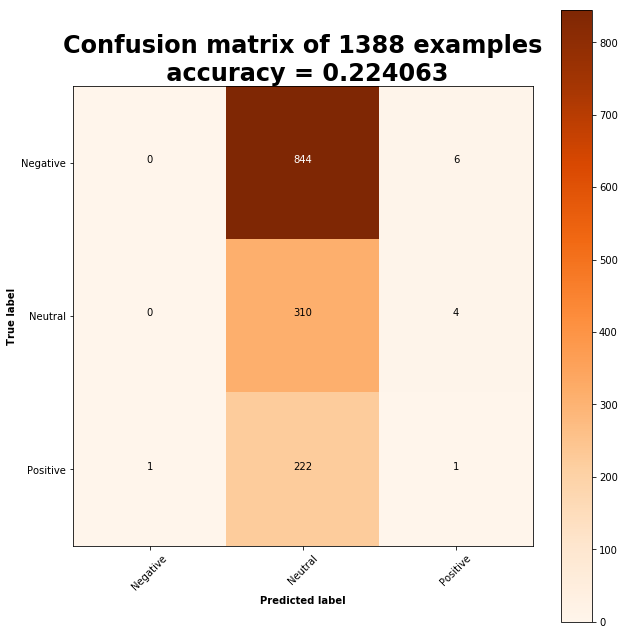

In [25]:
test_bach = next(iter(gopdata.test_iter))
_, pred, labels = model.evaluate_bach(test_bach)

plot_confusion_matrix(truth=labels.numpy(),
                      predictions=pred.numpy(),
                      save=False,
                      path="rnn_confusion_matrix.png",
                      classes=labels_legend)

Criando a função para treinar o modelo

In [26]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        logits = model(batch.text)
        label = batch.label.type("torch.LongTensor")
        loss = criterion(logits, label)
        acc, _, _ = model.evaluate_bach(batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc

    mean_loss = epoch_loss / len(iterator)
    mean_acc = epoch_acc / len(iterator)
        
    return mean_loss, mean_acc


def get_valid_loss(model, valid_iter, criterion):
    batch = next(iter(valid_iter))
    model.eval()
    logits = model(batch.text)
    label = batch.label.type("torch.LongTensor")
    loss = criterion(logits, label)
    return loss

def training_loop_text_classification(model, config, dataholder, model_path, verbose=True):
    """
    Train a model for text classification

    :param model: RNN classification model
    :type model: 
    :param config: image classification model
    :type config: LogisticRegression or DFN
    :param dataholder: data
    :type dataholder: DataHolder or DataHolderGentle
    :param model_path: path to save model params
    :type model_path: str
    :param verbose: param to control print
    :type verbose: bool
    """
    optimizer = optim.SGD(model.parameters(),
                          lr=config.learning_rate,
                          momentum=config.momentum)
    
    criterion = nn.CrossEntropyLoss()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = criterion.to(device)
    train_iter = dataholder.train_iter
    valid_iter = dataholder.valid_iter
    
    best_valid_loss = float("inf")
    
    for epoch in range(config.epochs):
        print("epoch = ({}/{})".format(epoch + 1, config.epochs))
        train_loss, train_acc = train(model, train_iter, optimizer, criterion)
        valid_loss = get_valid_loss(model,valid_iter, criterion)
        msg = "\ntrain_loss = {:.3f} | valid_loss = {:.3f}".format(float(train_loss),float(valid_loss))
        if float(valid_loss) < best_valid_loss:
            torch.save(model.state_dict(), model_path)
            best_valid_loss = float(valid_loss)
        if verbose:
            print(msg)
            print("train_acc = {}\n".format(train_acc))    

In [27]:
training_loop_text_classification(model, config, gopdata, "rnn.pkl")

epoch = (1/3)

train_loss = 0.948 | valid_loss = 0.862
train_acc = 0.6006389776357828

epoch = (2/3)

train_loss = 0.941 | valid_loss = 0.838
train_acc = 0.6056309904153354

epoch = (3/3)

train_loss = 0.935 | valid_loss = 0.958
train_acc = 0.6093250798722045



Model's accuracy **after** the training

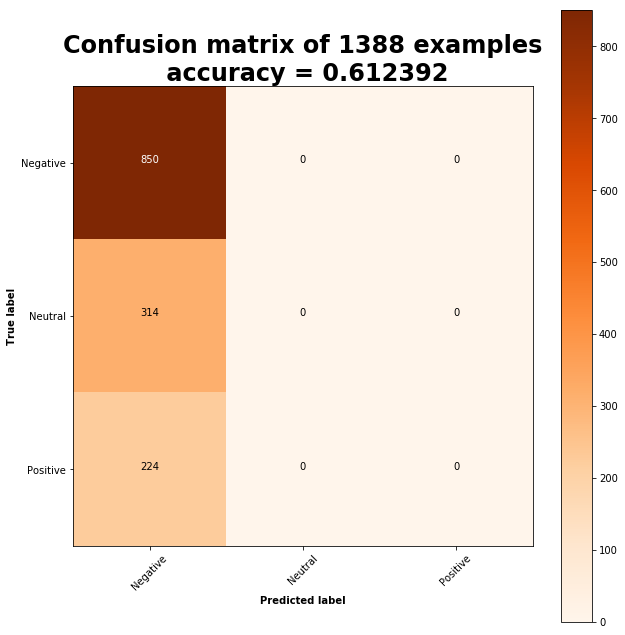

In [28]:
model = RNN(config)
model.load_state_dict(torch.load('rnn.pkl'))
_, pred, labels = model.evaluate_bach(test_bach)

plot_confusion_matrix(truth=labels.numpy(),
                      predictions=pred.numpy(),
                      save=False,
                      path="rnn_confusion_matrix.png",
                      classes=labels_legend)

Taking a look on some single examples

In [29]:
t1 = "I don't like Donald Trump"
t2 = "I like Donald Trump"
t3 = "I hate Donald Trump"
t4 = "I  like like like love Trump"
t5 = "#GOPDebate #JonVoyage - Thoughts on the events of last night on TV, including the Republican debate and Jon... http://t.co/pz4tiAOnBL"
tweets = [t1,t2,t3,t4,t5]

In [30]:
for tweet in tweets:
    print()
    print(tweet)
    text = simple_pre_process_text(tweet)
    text_as_int = [TEXT.vocab.stoi[word] for word in text.split(" ")]
    text_as_tensor = torch.Tensor(text_as_int).type('torch.LongTensor')
    text_as_tensor = text_as_tensor.view((1, text_as_tensor.shape[0]))
    text_as_tensor = text_as_tensor.t()  # putting in the format [sent len, batch size]
    pred = int(model.predict(text_as_tensor))
    print(LABEL.vocab.itos[pred])


I don't like Donald Trump
Negative

I like Donald Trump
Negative

I hate Donald Trump
Negative

I  like like like love Trump
Negative

#GOPDebate #JonVoyage - Thoughts on the events of last night on TV, including the Republican debate and Jon... http://t.co/pz4tiAOnBL
Negative
